# Project 03 - Generative Adversarial Networks and Conditional Generative Adversarial Networks

Hello and Welcome to our third project this Semster: GANs and cGANs.

__Deadline__: 08.01.2024 @ 14:30

__Submission__: Please upload your finished notebooks here: https://fz-juelich.sciebo.de/s/qIKELa6d9RFYls0. The name of the notebook should contain the HHU-ID of every member in your group. If you have more than one file, please upload them zipped.


## Project
In the last lectures you learned about Generative Adversarial Networks (GANs). They are a powerful generative model. In this project we want to dip our hands into training a GAN, which is by many still seen as "Black Magic". As there are many moving parts in GANs, we will keep it simple and train on the MNIST dataset. To make it a little more interesting, we will also try a conditional Generative Adversarial Network (cGAN).

## Part 1 - Generative Adversarial Network:
### Data
We will again use the higher resolution (28x28) [MNIST dataset](https://www.openml.org/search?type=data&status=any&id=554). You can download it to your notebook using [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html).

### Generative Adversarial Network
Our Generative Adversarial Network consists of two parts, the generator and the discriminator. The generator recieves a latent noise vector. This noise vector than gets transformed into an image through the network. The discriminator decides wheither the presented image is a fake or real image. U can use ur implementation of the VAE Decoder as part of the generator and the Encoder as part of the Discriminator. Our generator should map from a flat latent space of size 100 (use one Linear layer to transform this into something like 7x7x64). Add one (more) linear layers to your discriminator to get a binary output. Adapt your implementation of the GAN and your DataClass to follow some of the principals and best practices found [here](https://github.com/soumith/ganhacks). For an example training loop have a look [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

## Part 2 - conditional Generative Adversarial Network
### Data
For our first test with a cGAN we will use the same dataset again, to keep it simple.

### conditional Generative Adversarial Network
Mirza and Osindero first proposed the [cGAN](https://arxiv.org/pdf/1411.1784.pdf), a simple extenstion to the original GAN. In order to guide the generation process, they added a latent variable to the input of the generator which encodes some prior information. In our case this should be digit we want to generate. The discriminator also recieves this information about the input digit and decides weither the presented image is a good candidate for the digit.
The digit class should be one-hot encoded. You can add this encoded class to your GAN by adding another Linear Layer, that transforms your encoding into something like 7x7x2 which you can concatenate with the noise latent variable before your first convolution.

## Part 3 - SVHN
Only do this part if you have enough time. MNIST is a good base benchmark, but it lacks the noise of real world data. [SVHN](https://www.openml.org/search?type=data&status=active&id=41081) is a collection of House Numbers collected by Google. You can also fetch the dataset using [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html) (this may take some time, as SVHN is subtanially larger than MNIST). The images are of size 32x32 in RGB format. Each image is labeled 0-9 for the number seen in the center of the image.
Adapt your GAN and cGAN to ouput RGB images and to work with this image size.
Train your GAN and cGAN on the SVHN dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.datasets import fetch_openml

# torch imports
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchsummary import summary

from models import Generator, Discriminator, GANBuffer

### Data
1. Download the MNIST dataset
2. Create a dataset class to serve the images, scale the images between -1 and 1

In [2]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self):
        super().__init__()
        # get the data
        X, y = fetch_openml(
            "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
        )
        self.images = X.reshape((-1, 1, 28, 28)).astype("float32") / 127.5 - 1
        self.classes = torch.as_tensor(y.astype("int64"))

    def __getitem__(self, idx):
        return self.images[idx], self.classes[idx]

    def __len__(self):
        return len(self.images)

In [3]:
latent_size = 100

In [4]:
def viz(imgs, labels):
  fig, axes = plt.subplots(2, 8)
  for i in range(2):
      for j in range(8):
          axes[i, j].imshow(imgs[i*8+j].squeeze(), cmap="gray")
          axes[i, j].axis('off')
          if labels is not None:
            axes[i, j].set_title(labels[i*8+j].argmax().item())
  plt.show()

In [5]:
def train_one_epoch(data, generator, discriminator, generator_opt, discriminator_opt, buffer, device="cuda", conditional = False):
    losses_gen = []
    losses_disc = []
    loss_fn = torch.nn.MSELoss()

    tk0 = tqdm(data)
    for bidx, (data, label) in enumerate(tk0):
        # get the data
        real = data.to(device)
        label = torch.nn.functional.one_hot(label, num_classes=10).float().to(device) if conditional else None
        b_size = real.shape[0]
        # train the discriminator
        discriminator.zero_grad()

        # apply the discriminator to the real batch and calculate the loss
        real_d = discriminator(real, label)
        flip_probs = torch.full_like(real_d, 0.1, requires_grad=False)
        flip_mask = torch.bernoulli(flip_probs)

        err_real = loss_fn(real_d, torch.empty_like(real_d, requires_grad=False).uniform_(0.8, 1.2) - flip_mask)
        err_real.backward()

        # appl the discriminator to the fake batch and calculate the loss
        # Generate batch of latent vectors and fake images
        noise = torch.randn(b_size, latent_size, device=device)
        noise_label = torch.randint(0, 10, (b_size, ), device=device)
        noise_label = torch.nn.functional.one_hot(noise_label, num_classes=10).float() if conditional else None

        flip_mask = torch.bernoulli(flip_probs)
        fake = generator(noise, noise_label)
        #get buffered fakes
        fake_buf, label_buf = buffer.query(images = fake, labels = noise_label)
        fake_d = discriminator(fake_buf.detach(), label_buf)
        err_fake = loss_fn(fake_d, torch.empty_like(fake_d, requires_grad=False).uniform_(-0.2, 0.2) + flip_mask)
        err_fake.backward()

        # get the error and update the discriminator
        err_disc = err_real + err_fake
        discriminator_opt.step()

        # train the generator
        generator.zero_grad()

        # re-apply the discriminator, calculate the loss and run it backwards
        gen_d = discriminator(fake, noise_label)
        err_gen = loss_fn(gen_d, torch.ones_like(gen_d, requires_grad=False))
        err_gen.backward()
        # Update G
        generator_opt.step()

        # update our loss log
        losses_gen.append(err_gen.item())
        losses_disc.append(err_disc.item())
    viz(fake.detach().cpu(), noise_label)
    return np.asarray(losses_gen), np.asarray(losses_disc)

### Models

#### 1. Generative Adversarial Network

1. Get your implementation of your Decoder. Implement the Generator as described above.
2. Get your implementation of your Encoder. Implement the Discriminator based on this, as described above.
3. Implement a training loop like described in the DCGAN tutorial
4. Tune your generator and discriminator, apply improvements from the ganhacks github page.

In [7]:
#v11
generator = Generator(chs=(256, 64, 16)).cuda()
discriminator = Discriminator(chs=(1, 64, 128)).cuda()

In [9]:
epochs = 35
lr = 10**-4
batch_size = 64

train_loader = DataLoader(MNISTDataset(), batch_size=batch_size, pin_memory=True, shuffle=True)

Epoch: 1 - Training


100%|██████████| 2188/2188 [00:39<00:00, 55.31it/s]


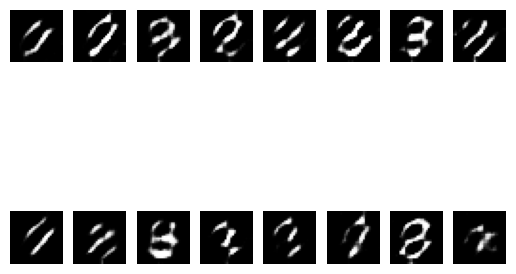

Epoch: 2 - Training


100%|██████████| 2188/2188 [00:39<00:00, 56.03it/s]


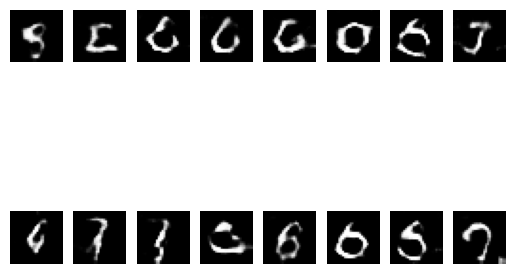

Epoch: 3 - Training


100%|██████████| 2188/2188 [00:39<00:00, 54.80it/s]


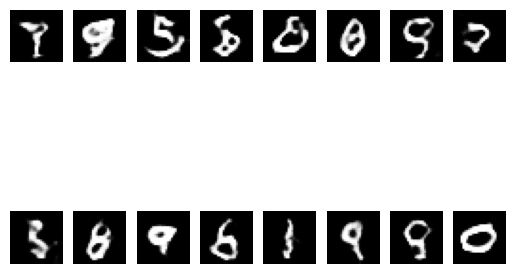

Epoch: 4 - Training


100%|██████████| 2188/2188 [00:41<00:00, 52.17it/s]


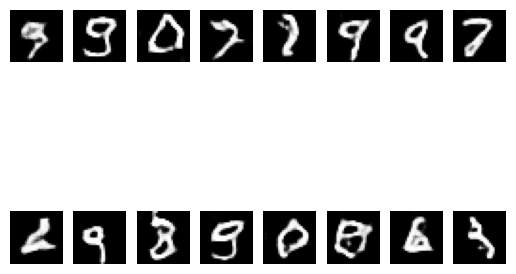

Epoch: 5 - Training


100%|██████████| 2188/2188 [00:39<00:00, 55.51it/s]


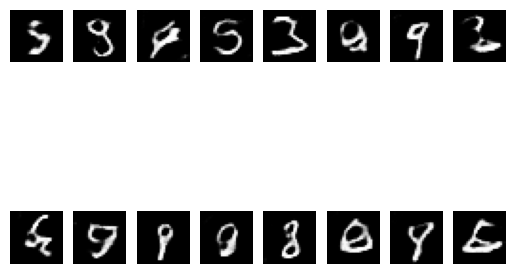

In [16]:
# get the optimizer
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr*2)

# run the training
losses_gen = None
losses_disc = None
fake_buffer = GANBuffer()
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} - Training")
    # do the training
    loss_gen, loss_disc = train_one_epoch(train_loader, generator, discriminator, gen_opt, disc_opt, fake_buffer)

    # gather losses
    losses_gen = loss_gen if losses_gen is None else np.concatenate((losses_gen, loss_gen))
    losses_disc = loss_disc if losses_disc is None else np.concatenate((losses_disc, loss_disc))
del(fake_buffer)

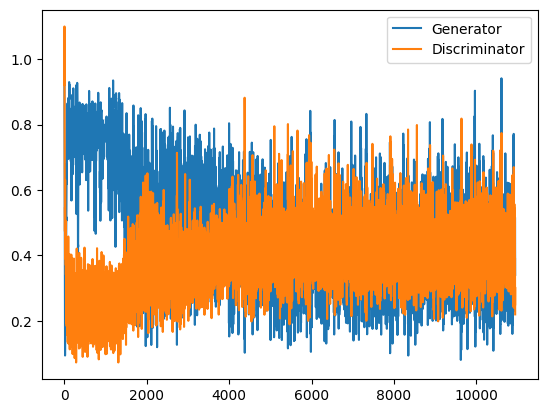

In [17]:
plt.plot(losses_gen, label="Generator")
plt.plot(losses_disc, label="Discriminator")
plt.legend()
plt.savefig("v11.png")
plt.show()

In [14]:
generator.load_state_dict(torch.load(".\\gan.pt"))

<All keys matched successfully>

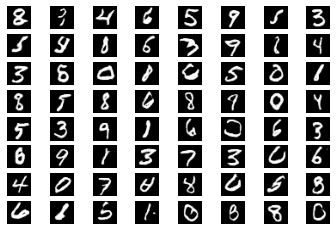

In [15]:
# generate some images
b_size = 64
device = "cuda"
with torch.no_grad():
    noise = torch.randn(b_size, latent_size, device=device)
    fake = generator(noise).cpu()

fig, axes = plt.subplots(8, 8)
for i in range(8):
    for j in range(8):
        axes[i, j].imshow(fake[i*8+j].squeeze(), cmap="gray")
        axes[i, j].axis('off')
plt.savefig("v11-images.png")
plt.show()

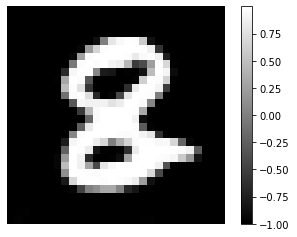

In [16]:
plt.imshow(fake[0, 0], cmap="gray")
plt.axis('off')
plt.colorbar()
plt.show()

##### Interpolation

Choose a few pairs of z-vector and interpolate between them. Describe the results, do they work as intended?

In [25]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)
b_size = 2

with torch.no_grad():
    noise = torch.randn(b_size, latent_size, device=device)
    # Define the number of example images you want to display
    N = 10
    # Interpolate
    A, B = noise[0], noise[1]
    C = B - A
    interpolated_vectors = [A + i*C for i in np.linspace(0, 1, N)]
    interpolated_imgs = [generator(vector.unsqueeze(0)).cpu() for vector in interpolated_vectors]

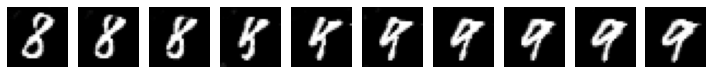

In [26]:
# Plot interpolated images
plt.figure(figsize=(10, 5))

for i in range(N):
    plt.subplot(1, N, i + 1)  
    plt.imshow(interpolated_imgs[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

#### 2. conditional Generative Adversarial Network
1. Adapt your GAN to accept an additional conditional vector for the digit class
2. Train the conditional GAN on the MNIST dataset

In [12]:
generator = Generator(chs=(256, 64, 16), num_classes=10).cuda()
discriminator = Discriminator(chs=(1, 64, 128), num_classes=10).cuda()

In [7]:
# generator.load_state_dict(torch.load(".\\cgan.pt"))

<All keys matched successfully>

In [13]:
epochs = 13
lr = 10**-4
batch_size = 64


In [8]:

train_loader = DataLoader(MNISTDataset(), batch_size=batch_size, pin_memory=True, shuffle=True)

Epoch: 1 - Training


100%|██████████| 1094/1094 [00:29<00:00, 37.06it/s]


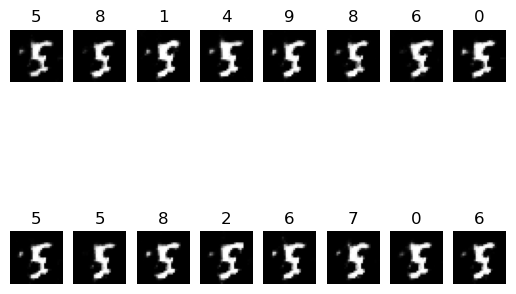

Epoch: 2 - Training


100%|██████████| 1094/1094 [00:29<00:00, 36.62it/s]


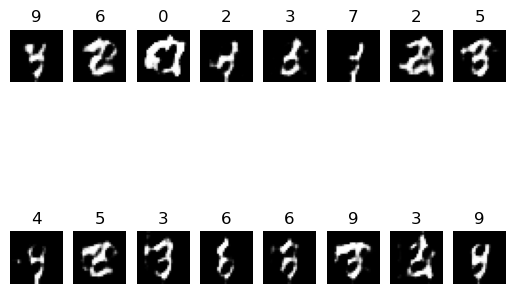

Epoch: 3 - Training


100%|██████████| 1094/1094 [00:30<00:00, 35.37it/s]


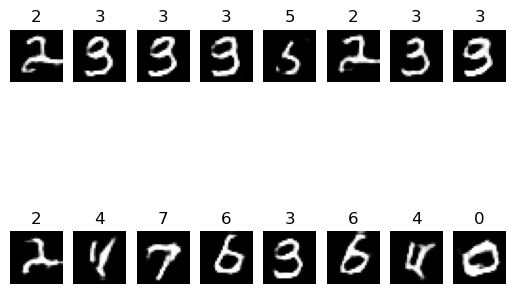

Epoch: 4 - Training


100%|██████████| 1094/1094 [00:33<00:00, 33.08it/s]


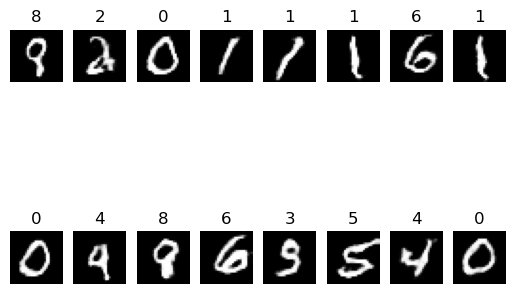

Epoch: 5 - Training


100%|██████████| 1094/1094 [00:35<00:00, 31.11it/s]


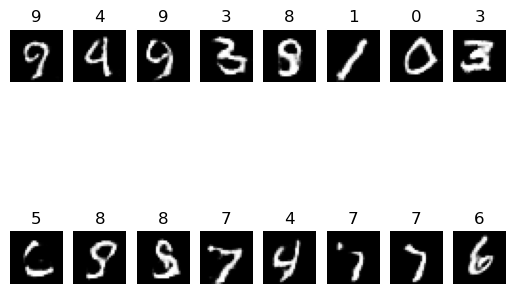

Epoch: 6 - Training


100%|██████████| 1094/1094 [00:36<00:00, 30.18it/s]


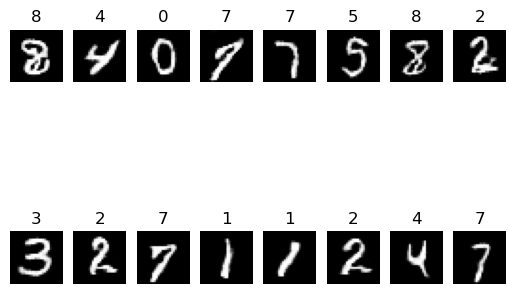

Epoch: 7 - Training


100%|██████████| 1094/1094 [00:39<00:00, 27.93it/s]


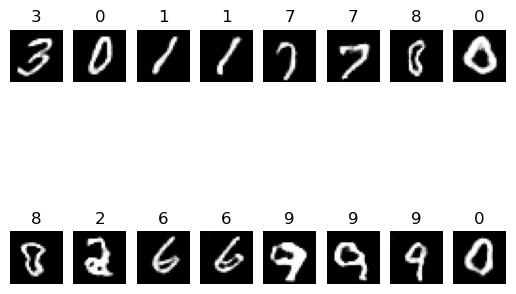

Epoch: 8 - Training


100%|██████████| 1094/1094 [00:40<00:00, 27.34it/s]


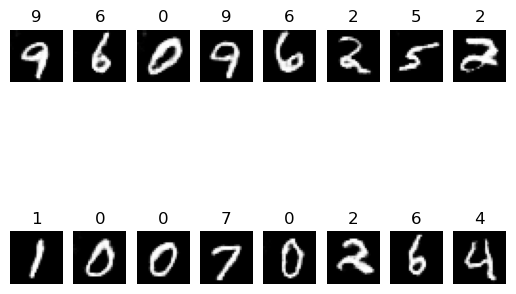

Epoch: 9 - Training


100%|██████████| 1094/1094 [00:42<00:00, 25.97it/s]


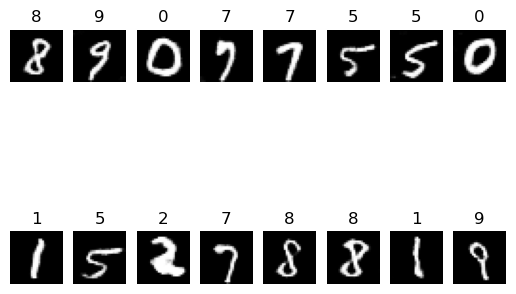

Epoch: 10 - Training


100%|██████████| 1094/1094 [00:42<00:00, 25.94it/s]


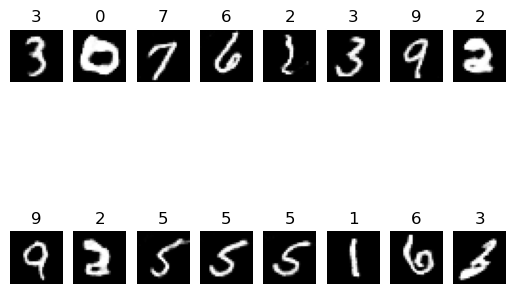

Epoch: 11 - Training


100%|██████████| 1094/1094 [00:42<00:00, 25.97it/s]


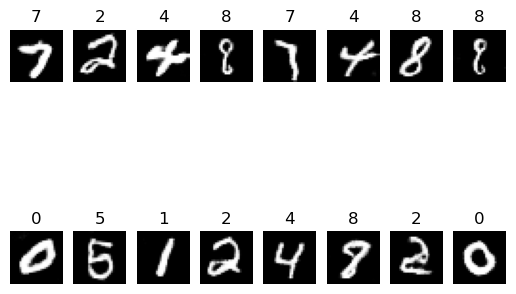

Epoch: 12 - Training


100%|██████████| 1094/1094 [00:42<00:00, 25.75it/s]


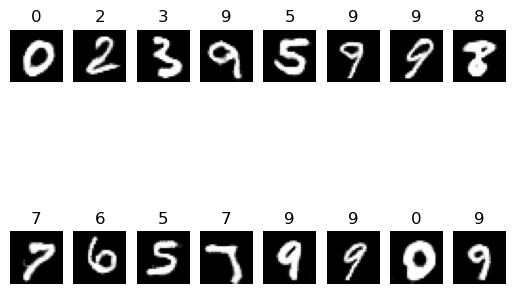

Epoch: 13 - Training


100%|██████████| 1094/1094 [00:39<00:00, 27.52it/s]


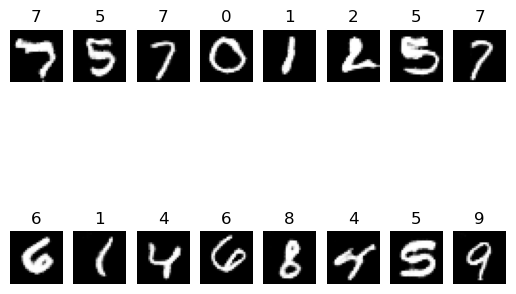

In [14]:
# get the optimizer
gen_opt = torch.optim.Adam(generator.parameters(), lr=lr, betas = (0.5, 0.999))
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=lr, betas = (0.5, 0.999))

# run the training
losses_gen = None
losses_disc = None
fake_buffer = GANBuffer()
for epoch in range(epochs):
    print(f"Epoch: {epoch+1} - Training")
    # do the training
    loss_gen, loss_disc = train_one_epoch(train_loader, generator, discriminator, gen_opt, disc_opt, fake_buffer, conditional=True)

    # gather losses
    losses_gen = loss_gen if losses_gen is None else np.concatenate((losses_gen, loss_gen))
    losses_disc = loss_disc if losses_disc is None else np.concatenate((losses_disc, loss_disc))
del(fake_buffer)

In [15]:
torch.save(generator.state_dict(), "cgan.pt")

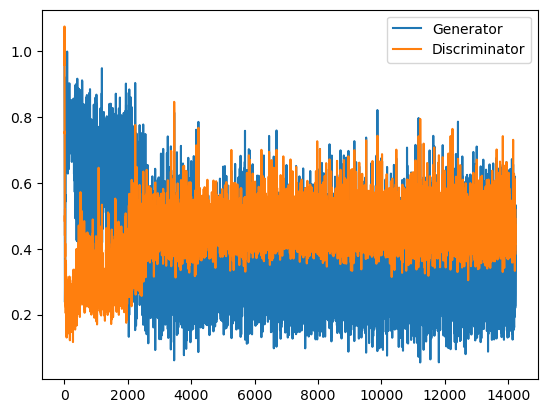

In [16]:
plt.plot(losses_gen, label="Generator")
plt.plot(losses_disc, label="Discriminator")
plt.legend()
plt.savefig("v11_cond.png")
plt.show()

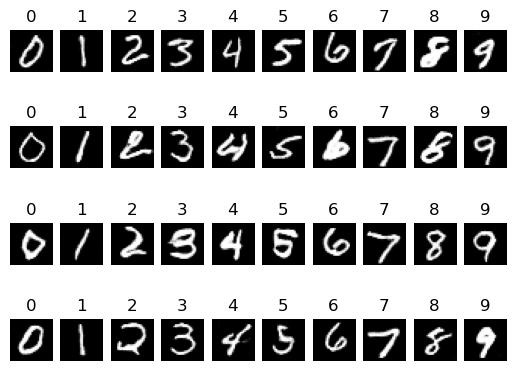

In [30]:
# generate some images
b_size = 40
device = "cuda"
with torch.no_grad():
    noise = torch.randn(b_size, latent_size, device=device)
    labels = torch.nn.functional.one_hot(torch.arange(0, 10, device=device).repeat(4), num_classes=10)
    fake = generator(noise, labels).cpu()

fig, axes = plt.subplots(4, 10)
for i in range(4):
    for j in range(10):
        axes[i, j].imshow(fake[i*10+j].squeeze(), cmap="gray")
        axes[i, j].axis('off')
        axes[i, j].set_title(labels[i*10+j].argmax().item())
plt.savefig("v11-images_cond.png")
plt.show()

##### Interpolation in z-space

Choose a few pairs of z-vectors and interpolate between them. Keep the digit class constant. What changes, if anything?

In [24]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)
b_size = 2
device='cuda'
with torch.no_grad():
    noise = torch.randn(b_size, latent_size, device=device)
    label = torch.nn.functional.one_hot(torch.randint(0, 10, (1, ), device=device), num_classes=10)
    # Define the number of example images you want to display
    N = 10
    # Interpolate
    A, B = noise[0], noise[1]
    C = B - A
    interpolated_vectors = [A + i*C for i in np.linspace(0, 1, N)]
    interpolated_imgs = [generator(vector.unsqueeze(0), label).cpu() for vector in interpolated_vectors]

8


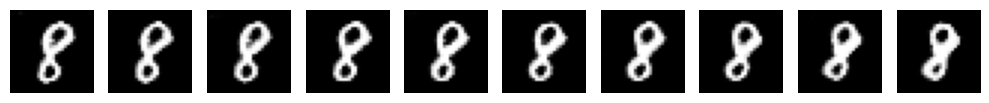

In [25]:
# Plot interpolated images
plt.figure(figsize=(10, 5))
print(label.argmax().item())
for i in range(N):
    plt.subplot(1, N, i + 1)  
    plt.imshow(interpolated_imgs[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

##### Interpolate in label-space

Choose a few pairs of labels and interpolate between them. Keep the noise vector constant. What changes?

In [28]:
# Get a batch of data from the DataLoader
dataiter = iter(train_loader)
images, labels = next(dataiter)
b_size = 2
device='cuda'
with torch.no_grad():
    noise = torch.randn(1, latent_size, device=device)
    label = torch.nn.functional.one_hot(torch.randint(0, 10, (b_size, ), device=device), num_classes=10)
    # Define the number of example images you want to display
    N = 10
    # Interpolate
    A, B = label[0], label[1]
    C = B - A
    interpolated_vectors = [A + i*C for i in np.linspace(0, 1, N)]
    interpolated_imgs = [generator(noise, vector.unsqueeze(0)).cpu() for vector in interpolated_vectors]

tensor([5, 9], device='cuda:0')


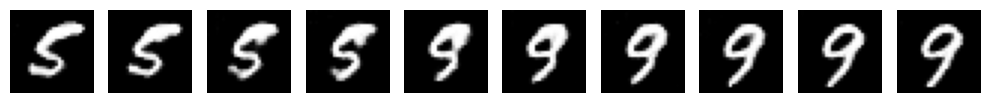

In [29]:
# Plot interpolated images
plt.figure(figsize=(10, 5))
print(label.argmax(1))
for i in range(N):
    plt.subplot(1, N, i + 1)  
    plt.imshow(interpolated_imgs[i].squeeze(), cmap='gray')  # Squeeze removes the batch dimension
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

#### 3. SVHN

1. Downloat the SVHN dataset and write a dataset class for it.
2. Adapt your GAN and cGAN to match the SVHN images.
3. Train it.
4. Try generation and interpolation in the z- and label-space. What do you see?